<a href="https://colab.research.google.com/github/Chirag314/EDA/blob/main/titanic_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import missingno
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
#from catboost import CatBoostClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install kaggle
!mkdir ~/.kaggle 
!cp train.csv ~/.kaggle
!cp test.csv ~/.kaggle
!chmod 600 ~/.kaggle/train.csv
!chmod 600 ~/.kaggle/test.csv


In [3]:
#Import data
#train=pd.read_csv(r'C:/Input/Titanic/train.csv')
import os
trainfile='train.csv'

train = pd.read_csv(trainfile)
test=pd.read_csv('test.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.describe()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
# Define the function that creates missing value heatmap
def plot_missing_data(dataset, title):
  fig,ax=plt.subplots(figsize=(5,5))
  plt.title(title)
  sns.heatmap(dataset,cbar=False)

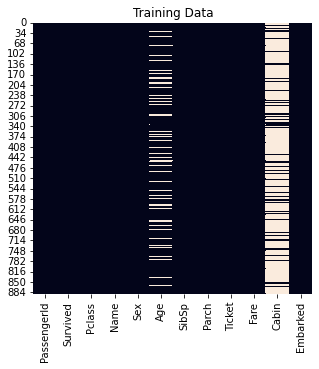

In [6]:
plot_missing_data(train.isnull(),"Training Data")

In [7]:
# Since Cabin has 80 % missing data. No point in keepint it in the dataset. Lets drop it.
train.drop(['Cabin'],axis=1,inplace=True)
test.drop(['Cabin'],axis=1,inplace=True)

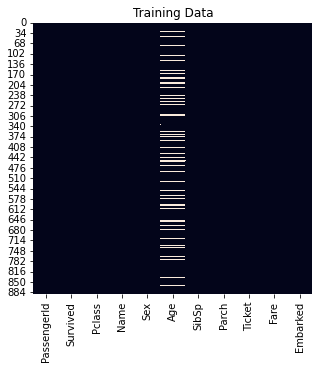

In [8]:
plot_missing_data(train.isnull(),"Training Data")

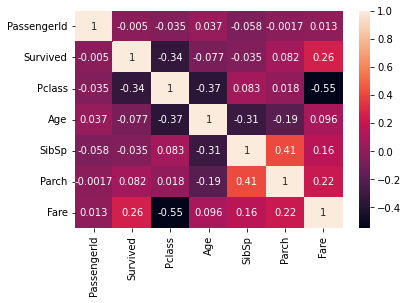

In [9]:
# LEts check correlation matric to find out which features are important in prediction survival

corrMatrix = train.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

# We can see from the map that pclass and fare are highly correlated with survived. Lets analyse them further.

In [10]:
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [11]:
# Check fare*survived frequency

train.groupby(['Fare', 'Survived'])['Fare'].count().unstack()

Survived,0,1
Fare,,
0.0000,14.0,1.0
4.0125,1.0,NaN
5.0000,1.0,NaN
6.2375,1.0,NaN
6.4375,1.0,NaN
...,...,...
227.5250,1.0,3.0
247.5208,1.0,1.0
262.3750,NaN,2.0


In [12]:
# Check pclass*survived frequency

train.groupby(['Pclass', 'Survived'])['Pclass'].count().unstack()

Survived,0,1
Pclass,,
1,80,136
2,97,87
3,372,119


In [13]:
# Check sex*survived frequency

train.groupby(['Sex', 'Survived'])['Sex'].count().unstack()

Survived,0,1
Sex,,
female,81,233
male,468,109


In [14]:
# Check embarked*survived frequency

train.groupby(['Embarked', 'Survived'])['Embarked'].count().unstack()

Survived,0,1
Embarked,,
C,75,93
Q,47,30
S,427,217


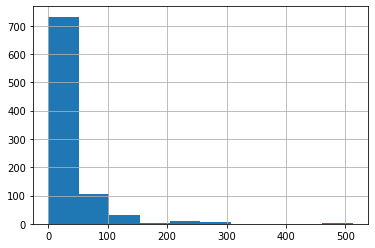

In [15]:
train['Fare'].hist()

In [16]:
scaler=MinMaxScaler()
train['Fare']=scaler.fit_transform(train[['Fare']])
test['Fare']=scaler.fit_transform(test[['Fare']])

In [17]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,0.014151,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,0.139136,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,0.015469,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,0.103644,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,0.015713,S


In [18]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,0.062858
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,0.096995
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,0.015440
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,0.028213
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,0.060508
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,1.000000


In [19]:
# checking the missing values
train.isnull().sum()
#We can see that Age has 177 missing values out of 891. Thus we can do the missing values imputation. However, let’s leave it for the next advanced tutorial. For now, let’s not take the Age column. So for model input, we will have only Passenger class and Sex. The output is the Survived field.

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         2
dtype: int64

In [20]:
# Impute missing values for Embarked
mode=train['Embarked'].value_counts().index[0]
train['Embarked']=train['Embarked'].fillna(mode)
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         0
dtype: int64

In [21]:
test.isnull().sum()

PassengerId     0
Pclass          0
Name            0
Sex             0
Age            86
SibSp           0
Parch           0
Ticket          0
Fare            1
Embarked        0
dtype: int64

In [22]:
# Impute missing values for fare in test data
mode=test['Fare'].value_counts().index[0]
test['Fare']=test['Fare'].fillna(mode)
test.isnull().sum()

PassengerId     0
Pclass          0
Name            0
Sex             0
Age            86
SibSp           0
Parch           0
Ticket          0
Fare            0
Embarked        0
dtype: int64

In [23]:
# Impute age with mean values

train["Age"]= train["Age"].fillna(train["Age"].mean())
### Plotting People On Different Age Groups
train.Age = train.Age.astype(int)

In [26]:
# View age distribution and convert into categories
temp=train.copy()
temp['Age']=pd.cut(temp["Age"],bins=[0,12,20,40,120],labels=["Children", "Teenage","Adult","Elder"])

AttributeError: ignored

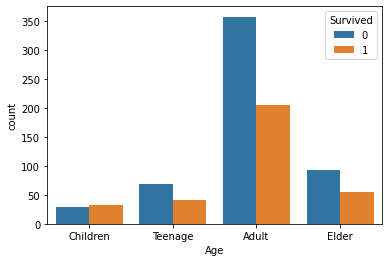

In [29]:
ax=sns.countplot(data=temp,x='Age',hue='Survived')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.legend(title='Survived or not',loc='upper right',labels=['No','Yes'])
plt.title('Age vs Survived')
plt.show()


In [24]:
# lets onlytake few columns for ease in alaysis
train_x=train[["Pclass", "Sex","Fare","Embarked" ,"Age"]]#Cabin","Embarked"]]
train_x.head()

,Pclass,Sex,Fare,Embarked,Age
0,3,male,0.014151,S,22
1,1,female,0.139136,C,38
2,3,female,0.015469,S,26
3,1,female,0.103644,S,35
4,3,male,0.015713,S,35


In [232]:
# lets onlytake two columns for ease in alaysis
test_x=test[["Pclass", "Sex","Fare","Embarked"]]#Cabin","Embarked"]]
test_x.head()

,Pclass,Sex,Fare,Embarked
0,3,male,0.015282,Q
1,3,female,0.013663,S
2,2,male,0.018909,Q
3,3,male,0.016908,S
4,3,female,0.023984,S


In [233]:
# Selecting output variable
train_y= train[["Survived"]]
train_y.head()

,Survived
0,0
1,1
2,1
3,1
4,0


In [234]:
# Cleaning of the data
train_x["Sex"].replace("male",1,inplace=True)
train_x["Sex"].replace("female",0,inplace=True)
train_x["Embarked"].replace("Q",1,inplace=True)
train_x["Embarked"].replace("C",2,inplace=True)
train_x["Embarked"].replace("S",3,inplace=True)
train_x.head()

,Pclass,Sex,Fare,Embarked
0,3,1,0.014151,3
1,1,0,0.139136,2
2,3,0,0.015469,3
3,1,0,0.103644,3
4,3,1,0.015713,3


In [235]:
# Cleaning of the test data
test_x["Sex"].replace("male",1,inplace=True)
test_x["Sex"].replace("female",0,inplace=True)
test_x["Embarked"].replace("Q",1,inplace=True)
test_x["Embarked"].replace("C",2,inplace=True)
test_x["Embarked"].replace("S",3,inplace=True)
test_x.head()

,Pclass,Sex,Fare,Embarked
0,3,1,0.015282,1
1,3,0,0.013663,3
2,2,1,0.018909,1
3,3,1,0.016908,3
4,3,0,0.023984,3


In [236]:
train_x=train_x[["Pclass", "Sex","Fare"]]#Cabin","Embarked"]]
test_x=test_x[["Pclass", "Sex","Fare"]]#Cabin","Embarked"]]
train_x.head()

,Pclass,Sex,Fare
0,3,1,0.014151
1,1,0,0.139136
2,3,0,0.015469
3,1,0,0.103644
4,3,1,0.015713


In [237]:
# Splitting dataset
tr_x, cv_x, tr_y, cv_y=train_test_split(train_x, train_y,test_size=0.2)
len(tr_x),len(cv_x),len(tr_y),len(cv_y)

(712, 179, 712, 179)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f615f3e6c10>,
      dtype=object)

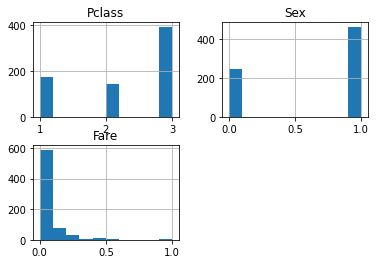

In [238]:
tr_x.hist()

In [239]:
#choose and train the model.
rf=RandomForestClassifier()


In [240]:

#Fit the training and test data
rf.fit(tr_x,tr_y)

RandomForestClassifier()

In [241]:
# Evaluate the model
accuracy_randomforest=rf.score(cv_x, cv_y)
print("Accuracy- {}%".format(accuracy_randomforest*100))

Accuracy- 81.56424581005587%


In [242]:
test_x.head()

,Pclass,Sex,Fare
0,3,1,0.015282
1,3,0,0.013663
2,2,1,0.018909
3,3,1,0.016908
4,3,0,0.023984


In [243]:
prd=rf.predict(test_x)
prd

array([0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [244]:
op=test[["PassengerId"]]
op['Survived']=prd
op.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [245]:
op.to_csv("Sub1.csv", index=False)

In [246]:
#USe NN to predict survival rate

# Set random seed
tf.random.set_seed(42)

# Create a model
model_1 = tf.keras.Sequential([
  tf.keras.layers.Dense(60, activation=tf.keras.activations.relu), # hidden layer 1, ReLU activation
  tf.keras.layers.Dense(40, activation=tf.keras.activations.relu), # hidden layer 2, ReLU activation
 tf.keras.layers.Dense(20, activation=tf.keras.activations.relu), # hidden layer 2, ReLU activation 
  tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid) # ouput layer, sigmoid activation
])

# Compile the model
model_1.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(lr=0.001),
                metrics=['accuracy'])

# Fit the model
history = model_1.fit(tr_x, tr_y, epochs=50,validation_data=(cv_x, cv_y))
model_1.evaluate(tr_x,tr_y)

Epoch 1/50
23/23 [==============================] - 1s 24ms/step - loss: 0.6517 - accuracy: 0.6124 - val_loss: 0.6273 - val_accuracy: 0.6145
Epoch 2/50
23/23 [==============================] - 0s 8ms/step - loss: 0.6190 - accuracy: 0.6166 - val_loss: 0.5999 - val_accuracy: 0.6145
Epoch 3/50
23/23 [==============================] - 0s 11ms/step - loss: 0.5953 - accuracy: 0.6166 - val_loss: 0.5683 - val_accuracy: 0.6369
Epoch 4/50
23/23 [==============================] - 0s 8ms/step - loss: 0.5671 - accuracy: 0.6966 - val_loss: 0.5286 - val_accuracy: 0.8045
Epoch 5/50
23/23 [==============================] - 0s 9ms/step - loss: 0.5391 - accuracy: 0.7767 - val_loss: 0.4928 - val_accuracy: 0.8212
Epoch 6/50
23/23 [==============================] - 0s 7ms/step - loss: 0.5194 - accuracy: 0.7781 - val_loss: 0.4690 - val_accuracy: 0.8212
Epoch 7/50
23/23 [==============================] - 0s 9ms/step - loss: 0.5084 - accuracy: 0.7795 - val_loss: 0.4572 - val_accuracy: 0.8212
Epoch 8/50
23/23 [

[0.4587995111942291, 0.7794944047927856]

In [247]:
# Use logistic regression 
lgr=LogisticRegression()
lgr.fit(tr_x,tr_y)

LogisticRegression()

In [248]:
accuracy=lgr.score(cv_x,cv_y)
print("Accuracy ={}%".format(accuracy*100))

Accuracy =82.12290502793296%


In [249]:
# Predict for logistic regression
prl=lgr.predict(test_x)
prl

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [250]:
op2=test[['PassengerId']]
op2['Survived']=prl
op2.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [251]:
op2.to_csv("Sub2.csv",index=False)

In [252]:
# Check accuracy against all other binary classifiers
models = {}
# Logistic regression

from sklearn.linear_model import LogisticRegression
models['Logistic Regression']=LogisticRegression(solver='lbfgs', max_iter=3000)

# Support vector machines
from sklearn.svm import LinearSVC
models['Support Vector Machines']=LinearSVC(max_iter=3000)

#Decision trees
from sklearn.tree import DecisionTreeClassifier
models['Decision Trees']=DecisionTreeClassifier()

# Random forest 
from sklearn.ensemble import RandomForestClassifier
models['Random Forest']=RandomForestClassifier()

# Naive bayes
from sklearn.naive_bayes import GaussianNB
models['Naive Bayes']= GaussianNB()

#k-nearest neighbors
from sklearn.neighbors import KNeighborsClassifier
models['k-neares neighbors']=KNeighborsClassifier()

#Extra tree classifier
from sklearn.ensemble import ExtraTreesClassifier
models['Extra tree Classifier'] = ExtraTreesClassifier()
#Light GBM 
from lightgbm import LGBMClassifier
#from lightgbm import log_evaluation, early_stopping
models['Light GBM Classifier'] = LGBMClassifier(objective='binary',
                     learning_rate=0.01,
                     num_iterations=700,
                     max_depth=7)

In [253]:
## Import metrics

from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy, precision, recall ={}, {},{}

for key in models.keys():
  # Fit the model
  models[key].fit(tr_x, tr_y)

  # Prediction 
  prediction=models[key].predict(cv_x)

  # Calculate metrics
  accuracy[key]=accuracy_score(prediction,cv_y)
  precision[key]=precision_score(prediction,cv_y)
  recall[key]=recall_score(prediction, cv_y)

In [254]:
import pandas as pd
df_model = pd.DataFrame(index=models.keys(),columns=['Accuracy','Precision','Recall'])
df_model['Accuracy']=accuracy.values()
df_model['Precision']=precision.values()
df_model['Recall']=recall.values()

df_model

,Accuracy,Precision,Recall
Logistic Regression,0.821229,0.753623,0.776119
Support Vector Machines,0.821229,0.753623,0.776119
Decision Trees,0.793296,0.739130,0.728571
Random Forest,0.804469,0.753623,0.742857
Naive Bayes,0.798883,0.782609,0.720000
k-neares neighbors,0.776536,0.681159,0.723077
Extra tree Classifier,0.810056,0.739130,0.761194
Light GBM Classifier,0.826816,0.724638,0.806452


In [137]:
# Use extra tree classifier
etc=ExtraTreesClassifier()
etc.fit(tr_x,tr_y)

ExtraTreesClassifier()

In [138]:
accuracy=etc.score(cv_x,cv_y)
print("Accuracy ={}%".format(accuracy*100))

Accuracy =83.79888268156425%


In [139]:
# Predict for logistic regression
prl=etc.predict(test_x)
prl

array([0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [140]:
op2=test[['PassengerId']]
op2['Survived']=prl
op2.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [141]:
op2.to_csv("Sub3.csv",index=False)

In [142]:
# Use decision tree classifier
dt=DecisionTreeClassifier()
dt.fit(tr_x,tr_y)

DecisionTreeClassifier()

In [143]:
accuracy=dt.score(cv_x,cv_y)
print("Accuracy ={}%".format(accuracy*100))

Accuracy =84.35754189944134%


In [144]:
# Predict for logistic regression
pdt=dt.predict(test_x)
pdt

array([0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [145]:
op2=test[['PassengerId']]
op2['Survived']=pdt
op2.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [146]:
op2.to_csv("Sub4.csv",index=False)

In [148]:
test_x.head()

,Pclass,Sex,Fare,Embarked
0,3,1,0.015282,1
1,3,0,0.013663,3
2,2,1,0.018909,1
3,3,1,0.016908,3
4,3,0,0.023984,3
